# Lag-Llama Zero-Shot Time Series Forecasting

In this notebook we experiment with the zero shot performance of the lag-llama model on our test data.

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
%cd lag-llama

/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama


In [3]:
%pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /storage/BerlinWeatherTimeSeriesAnalysis/lag-llama

/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt


In [5]:
from itertools import islice

import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from torch.serialization import add_safe_globals
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch.distributions.studentT import StudentTOutput
add_safe_globals([NegativeLogLikelihood, StudentTOutput])

/tmp/ipykernel_1343/1310194502.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Model Setup

In [9]:
prediction_length = 24  # Predict one day ahead
context_length = prediction_length * 7 # One week context 
num_samples = 20
device = "cuda"
batch_size = 64

In [10]:
ckpt_path = "/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt"
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

zs_estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length,
    device=torch.device(device),

    # estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],
    
    nonnegative_pred_samples=True,

    # Linear Positional Encoding Scaling
    rope_scaling={
        "type":"linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },

    batch_size=batch_size,
    num_parallel_samples=num_samples
)


zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

Zero-Shot Prediction

In [ ]:
test_data = pd.read_csv("../data/2025_BME680SensorData.csv", usecols=columns)
test_data["ISO Time"] = pd.to_datetime(test_data["ISO Time"])
test_data["Date"] = test_data["ISO Time"].dt.date
test_data["Hour"] = test_data["ISO Time"].dt.hour
hourly_avg_test = test_data.groupby(["Date", "Hour"]).mean()
hourly_avg_test

test_data = hourly_avg_test["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
test_data = test_data.reset_index()
test_data['datetime'] = pd.to_datetime(test_data['Date']) + pd.to_timedelta(test_data['Hour'], unit='h')
test_data = test_data.set_index('datetime')
test_data.drop(columns=["Date", "Hour"], inplace=True)
test_data["Temperature (C)"] = test_data["Temperature (C)"].astype(np.float32)

In [12]:
#valid_end = round(len(test_data) * 0.9)
n_days_to_predict = 160
date_list = pd.date_range(test_data.index[2] + pd.Timedelta(hours=24), periods=n_days_to_predict, freq="1d").tolist()

zs_forecasts = []
zs_tss = []

for d in date_list:
  print(d)
  forecast_it, ts_it = make_evaluation_predictions(
          dataset=PandasDataset(test_data[:d], freq="1h", target="Temperature (C)"),
          predictor=zs_predictor,
          num_samples=num_samples
  )
  zs_forecasts.append(list(forecast_it))
  zs_tss.append(list(ts_it))


2025-01-02 02:00:00
2025-01-03 02:00:00
2025-01-04 02:00:00
2025-01-05 02:00:00
2025-01-06 02:00:00
2025-01-07 02:00:00
2025-01-08 02:00:00
2025-01-09 02:00:00
2025-01-10 02:00:00
2025-01-11 02:00:00
2025-01-12 02:00:00
2025-01-13 02:00:00
2025-01-14 02:00:00
2025-01-15 02:00:00
2025-01-16 02:00:00
2025-01-17 02:00:00
2025-01-18 02:00:00
2025-01-19 02:00:00
2025-01-20 02:00:00
2025-01-21 02:00:00
2025-01-22 02:00:00
2025-01-23 02:00:00
2025-01-24 02:00:00
2025-01-25 02:00:00
2025-01-26 02:00:00
2025-01-27 02:00:00
2025-01-28 02:00:00
2025-01-29 02:00:00
2025-01-30 02:00:00
2025-01-31 02:00:00
2025-02-01 02:00:00
2025-02-02 02:00:00
2025-02-03 02:00:00
2025-02-04 02:00:00
2025-02-05 02:00:00
2025-02-06 02:00:00
2025-02-07 02:00:00
2025-02-08 02:00:00
2025-02-09 02:00:00
2025-02-10 02:00:00
2025-02-11 02:00:00
2025-02-12 02:00:00
2025-02-13 02:00:00
2025-02-14 02:00:00
2025-02-15 02:00:00
2025-02-16 02:00:00
2025-02-17 02:00:00
2025-02-18 02:00:00
2025-02-19 02:00:00
2025-02-20 02:00:00


Evaluation

In [13]:
evaluator = Evaluator()
zs_a_metrics = [] # aggregated forecast metrics, we'll use the MAPE metric to evaluate
zs_t_metrics = [] # information about each time series, we'll use this to graph


mape_list = []
mase_list = []
mse_list = []
rmse_list = []

for (t, s) in tqdm(zip(zs_tss, zs_forecasts), total=len(zs_forecasts)):
    agg_metrics, ts_metrics = evaluator(t, s)
    zs_a_metrics.append(agg_metrics)
    zs_t_metrics.append(ts_metrics)
    
    # Extract the metrics
    mape = agg_metrics.get('MAPE')
    mase = agg_metrics.get('MASE')
    mse = agg_metrics.get('MSE')
    
    # Calculate RMSE from MSE
    rmse = np.sqrt(mse) if mse is not None else None
    
    # Append to lists
    mape_list.append(mape)
    mase_list.append(mase)
    mse_list.append(mse)
    rmse_list.append(rmse)

Running evaluation: 1it [00:01,  1.99s/it]
Running evaluation: 1it [00:01,  1.96s/it]s/it]
Running evaluation: 1it [00:01,  1.94s/it]s/it]
Running evaluation: 1it [00:02,  2.03s/it]s/it]
Running evaluation: 1it [00:02,  2.05s/it]s/it]
Running evaluation: 1it [00:01,  1.96s/it]s/it]
Running evaluation: 1it [00:01,  1.99s/it]s/it]
Running evaluation: 1it [00:02,  2.01s/it]s/it]
Running evaluation: 1it [00:01,  1.99s/it]s/it]
Running evaluation: 1it [00:02,  2.01s/it]s/it]
Running evaluation: 1it [00:01,  1.99s/it]6s/it]
Running evaluation: 1it [00:02,  2.11s/it]7s/it]
Running evaluation: 1it [00:02,  2.06s/it]6s/it]
Running evaluation: 1it [00:01,  1.99s/it]0s/it]
Running evaluation: 1it [00:01,  1.96s/it]8s/it]
Running evaluation: 1it [00:01,  1.93s/it]3s/it]
Running evaluation: 1it [00:01,  1.91s/it]3s/it]
Running evaluation: 1it [00:02,  2.06s/it]3s/it]
Running evaluation: 1it [00:02,  2.02s/it]7s/it]
Running evaluation: 1it [00:02,  2.01s/it]8s/it]
Running evaluation: 1it [00:02,  2.

In [23]:
print("Average Metrics (Over all predicted sequences)\n\n")
print(f"Average RMSE: {np.mean(rmse_list):.4f}")
print(f"Average MASE: {np.mean(mase_list):.4f}")
print(f"Average MAPE: {np.mean(mape_list)*100:.2f}%")

Average Metrics (Over all predicted sequences)


Average RMSE: 2.4306
Average MASE: 1.3988
Average MAPE: 73.81%


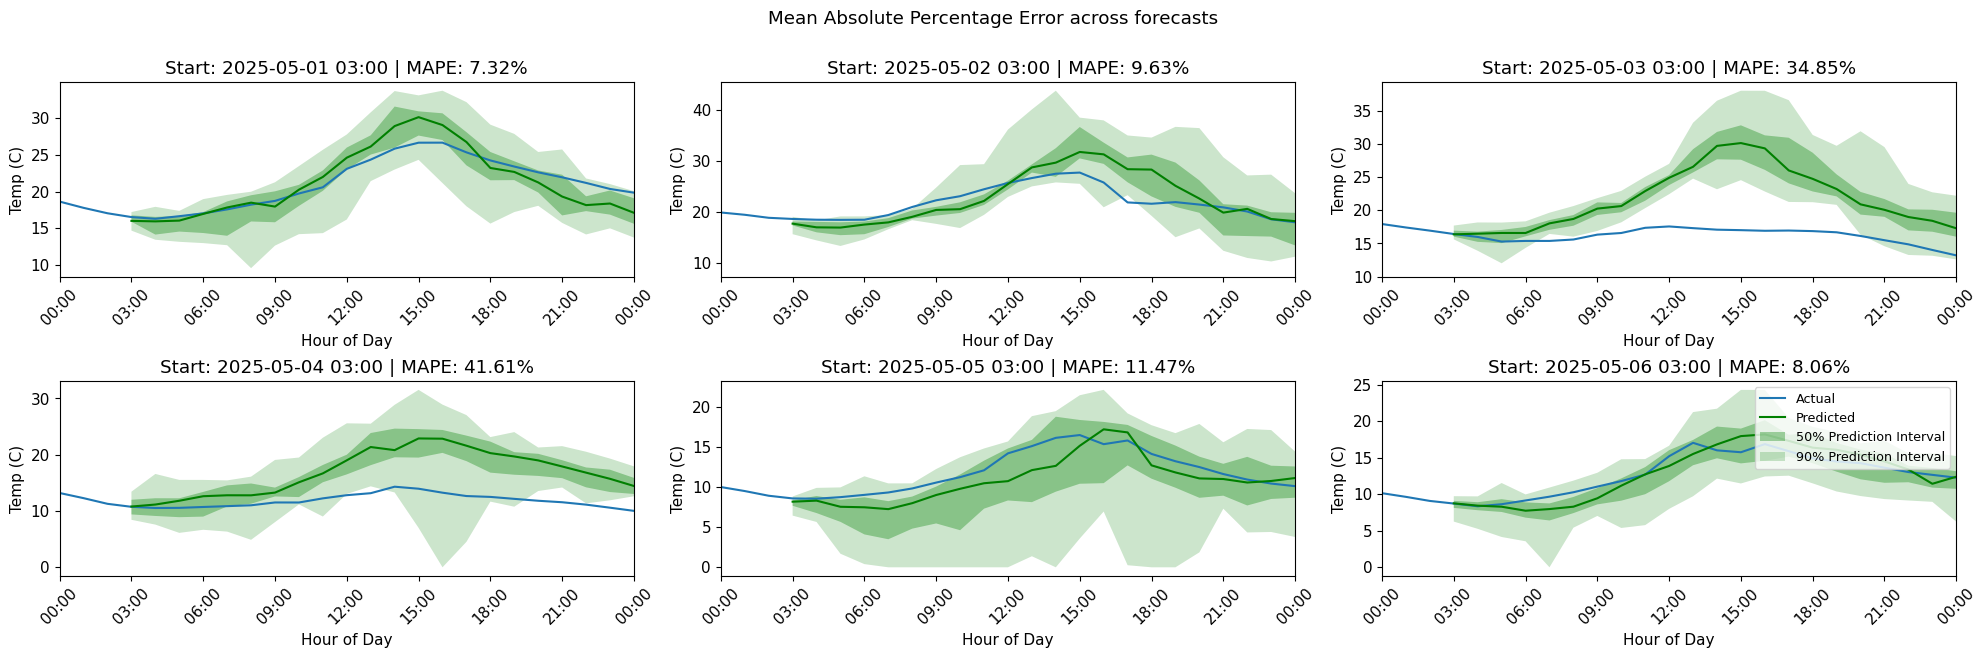

In [29]:
plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formatter = mdates.DateFormatter('%H:%M')

offset = 120
numplots = 6
for idx in range(len(zs_forecasts[offset:(offset+numplots)])):
    t_idx = idx + offset
    ax = plt.subplot(3, 3, idx+1)

    # Extract true series starting 12 hours before forecast
    forecast_start = zs_forecasts[t_idx][0].start_date.to_timestamp()
    t = zs_tss[t_idx][0][forecast_start - pd.Timedelta(hours=12):]

    # Plot true values
    ax.plot(t.index.to_timestamp(), t[0], label="Actual")

    # Plot forecast
    zs_forecasts[t_idx][0].plot(ax=ax, color='g')  # forecast includes prediction intervals

    # Set title with MAPE
    smape = float(f'{zs_t_metrics[t_idx]["MAPE"][0]:.4f}') * 100.0
    ax.set_title(f"Start: {zs_t_metrics[t_idx]['forecast_start'][0]} | MAPE: {smape:.2f}%")

    # Set x-axis format
    ax.xaxis.set_major_formatter(date_formatter)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Temp (C)')
    ax.tick_params(axis='x', rotation=45)

    # Set x-axis limits from 00:00 to 00:00 of the next day
    day_start = forecast_start.replace(hour=0, minute=0, second=0, microsecond=0)
    day_end = day_start + pd.Timedelta(days=1)
    ax.set_xlim([day_start, day_end])

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.legend(["Actual", "Predicted", '50% Prediction Interval', '90% Prediction Interval'], fontsize="small", loc='upper right')
plt.show()